In [2]:
import numpy as np
from random import random, seed
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def FrankeFunction(x,y):
    """Evaluate the Franke Function: a two-variables function to create the dataset of vanilla problems"""
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4
 
def Plot_FrankeFunction(x,y,z, title="Dataset"):
    """3D plot, suitable for plotting the Franke Function"""
    
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(projection='3d')
    #ax = fig.gca(projection="3d")

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_zlabel(r"$z$")
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(title)
    plt.show()
    
    
def create_xyz_dataset(n, mu, sigma):
    """ Create xyz dataset from the FrankeFunction with a added normal distributed noise.
    x,y variables are taken evenly distributed in the interval [0,1]
    
    Args:
    n (int): squared root of total number of datapoints
    mu (float): mean value of the normal distribution of the noise
    sigma (float): standard deviation of the normal distribution of the noise

    Returns x,y,z values, mashed on a grid.
    """
    x = np.linspace(0,1,n)
    y = np.linspace(0,1,n)

    x,y = np.meshgrid(x,y)
    z = FrankeFunction(x,y) + mu + sigma * np.random.randn(n,n)
    
    return x,y,z

def create_X(x, y, n):
    """Design matrix for two indipendent variables x,y"""
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2)		# Number of elements in beta, number of feutures (degree of polynomial)
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

In [1]:
# The MIT License (MIT)
#
# Copyright © 2021 Adele Zaini
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated
# documentation files (the “Software”), to deal in the Software without restriction, including without limitation the
# rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software,
# and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of
# the Software. THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT
# LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT
# SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF
# CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS
# IN THE SOFTWARE.

import numpy as np
from random import random, seed
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor


# Error analysis
def R2(y_data, y_model):
    """Compute the R2 score of the two given values"""
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    """Compute the Mean Square Error of the two given values"""
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n
    
def train_test_rescale(X_train, X_test, y_train, y_test, with_std=False):
    """Rescale train and test data using StandardScaler().
    The standard deviation correction is not applied by default.
    It's the analogous of train_test_split() by sklearn"""
    
    if len(y_train.shape) > 1:
        print("You forgot to ravel your outputs! \n Automatically ravelled in train_test_rescale()")
        y_train = np.ravel(y_train)
        y_test = np.ravel(y_test)
    
    scaler_X = StandardScaler(with_std=with_std)
    scaler_X.fit(X_train)
    X_train = scaler_X.transform(X_train)
    X_test = scaler_X.transform(X_test)

    scaler_y = StandardScaler(with_std=with_std)
    y_train = np.squeeze(scaler_y.fit_transform(y_train.reshape(-1, 1))) #scaler_y.fit_transform(y_train) #
    y_test = np.squeeze(scaler_y.transform(y_test.reshape(-1, 1))) #scaler_y.transform(y_test) #
    return X_train, X_test, y_train, y_test

def SVD(A):
    """ Application of SVD theorem.
    Useful for debugging. """
    U, S, VT = np.linalg.svd(A,full_matrices=True)
    D = np.zeros((len(U),len(VT)))
    print("shape D= ", np.shape(D))
    print("Shape S= ",np.shape(S))
    print("lenVT =",len(VT))
    print("lenU =",len(U))
    D = np.eye(len(U),len(VT))*S
    """
    for i in range(0,VT.shape[0]): #was len(VT)
        D[i,i]=S[i]
        print("i=",i)"""
    return U @ D @ VT
    
def SVDinv(A):
    """Evaluate the inverse of a matrix using the SVD theorem"""
    U, s, VT = np.linalg.svd(A)
    # reciprocals of singular values of s
    d = 1.0 / s
    # create m x n D matrix
    D = np.zeros(A.shape)
    # populate D with n x n diagonal matrix
    D[:A.shape[1], :A.shape[1]] = np.diag(d)
    UT = np.transpose(U)
    V = np.transpose(VT)
    return np.matmul(V,np.matmul(D.T,UT))
    
    
def GD(X, y, gradient, eta = 0.1, Niterations = 1000):
    """Gradient Descent Algorithm
    
        Args:
        - X (array): design matrix (training data)
        - y (array): output dataset (training data)
        - gradient (function): function to compute the gradient
        - eta (float): learning rate
        - Niterations (int): number of iteration
        
        Returns:
        beta/theta-values"""
    theta = np.random.randn(X.shape[1],1)

    for iter in range(Niterations):
        gradients = grandient(X, y, theta) #2.0/X.shape[0] * X.T @ ((X @ beta) - y)
        theta -= eta*gradients
        
    return theta
    
    
def learning_schedule(t, t0=5, t1=50):
    return t0/(t+t1)
    
def SGD(X,y, gradient, n_epochs, m, t0=5, t=50):
    """Stochastic Gradient Descent Algorithm
    
        Args:
        - X (array): design matrix (training data)
        - y (array): output dataset (training data)
        - gradient (function): function to compute the gradient
        - n_epochs (int): number of epochs
        - m (int): number of minibatches
        - t0 (float): initial paramenter to compute the learning rate
        - t1 (float): sequential paramenter to compute the learning rate
        
        Returns:
        beta/theta-values"""
        
    theta = np.random.randn(X.shape[1],1)
    
    for epoch in range(n_epochs):
        for i in range(m):
            random_index = np.random.randint(m)
            Xi = X[random_index:random_index+1]
            yi = y[random_index:random_index+1]
            gradients = gradient(Xi, yi, theta) * X.shape[0] #2.0 * Xi.T @ ((Xi @ theta)-yi)
            eta = learning_schedule(epoch*m+i, t0=t0, t1=t1)
            theta = theta - eta*gradients
            
    return theta
    
    
class LinearRegression:
    """A class that gathers OLS, Ridge, Lasso methods

    The 'fit' method needs to be implemented."""

    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def split(self,test_size=0.2):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size)
        return self
            
    def rescale(self, with_std=False): #Improvement: pass the Scaler
        """ y needs to be raveled """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_rescale(self.X_train, self.X_test, self.y_train, self.y_test, with_std = with_std)
        return self
    
    def fit(self):
        """Fit the model and return beta-values"""
        raise NotImplementedError("Method LinearRegression.fit is abstract and cannot be called")
        
    def fitSVD(self):
        """Fit the model and return beta-values, using SVD theorem to evalute the inverse of the matrix"""
        raise NotImplementedError("Method LinearRegression.fitSVD is abstract and cannot be called")
        
    def fit_SK(self):
        """Fit the model and return beta-values, using Scikit-Learn"""
        raise NotImplementedError("Method LinearRegression.fit_SK is abstract and cannot be called")
        
    def fitGD(self):
        """Fit the model and return beta-values, using the Gradient Descent"""
        raise NotImplementedError("Method LinearRegression.fitGD is abstract and cannot be called")
    
    def fitSGD(self):
        """Fit the model and return beta-values, using the Stochastic Gradient Descent"""
        raise NotImplementedError("Method LinearRegression.fitSGD is abstract and cannot be called")
        
    def get_param(self):
        return self.beta
    
    def predict_train(self):
        return self.X_train @ self.beta
        
    def predict_test(self):
        return self.X_test @ self.beta
    
    def MSE_train(self, prec=4):
        return np.round(MSE(self.y_train,self.predict_train()),prec)
        
    def MSE_test(self, prec=4):
        return np.round(MSE(self.y_test,self.predict_test()),prec)
        
    def R2_train(self, prec=4):
        return np.round(R2(self.y_train,self.predict_train()),prec)
        
    def R2_test(self, prec=4):
        return np.round(R2(self.y_test,self.predict_test()),prec)
        
    def Confidence_Interval(self, sigma=1):
        #Calculates variance of beta, extracting just the diagonal elements of the matrix
        #var(B_j)=sigma^2*(X^T*X)^{-1}_{jj}
        beta_variance = np.diag(sigma**2 * np.linalg.pinv(self.X.T @ self.X))
        ci1 = self.beta - 1.96 * np.sqrt(beta_variance)/(self.X.shape[0])
        ci2 = self.beta + 1.96 * np.sqrt(beta_variance)/(self.X.shape[0])
        print('Confidence interval of β-estimator at 95 %:')
        ci_df = {r'$β_{-}$': ci1,
                 r'$β_{ols}$': self.beta,
                 r'$β_{+}$': ci2}
        ci_df = pd.DataFrame(ci_df)
        display(np.round(ci_df,3))
        return ci1, ci2
        
"""
    def predict(self, X):
        Fit the model and return the prediction
        
        Args:
        X (array): design matrix

        Returns X*beta
        
        raise NotImplementedError("Method LinearRegression.predict is abstract and cannot be called")
"""

class OLSRegression(LinearRegression):
    
    def __init__(self, X, y):
        super().__init__(X, y)
        
    def fit(self):
        self.beta = np.linalg.pinv(self.X_train.T @ self.X_train) @ self.X_train.T @ self.y_train
        return self.beta
        
    def fitSVD(self):
        self.beta = SVDinv(self.X_train.T @ self.X_train) @ self.X_train.T @ self.y_train
        return self.beta
        
    def fit_SK(self):
        self.beta = SVDinv(self.X_train.T @ self.X_train) @ self.X_train.T @ self.y_train
        return self.beta
        
    def gradient(X, y, beta):
        return 2.0/X.shape[0] * X.T @ ((X @ beta) - y) # X.shape[0]=number of input (training) data
            
    def fitGD(self, eta = 0.1, Niterations = 1000):
                
        self.beta = GD(self.X_train, self.y_train, gradient=self.gradient, eta = eta, Niterations = Niterations)
        
        return self.beta
    
    def fitSGD(self, n_epochs, m, t0 = 5, t1 = 50):
          
        self.beta = SGD(X = self.X_train, y = self.y_train, gradient = self.gradient, n_epochs = n_epochs, m = m, t0 = t0, t1 = t1)
        
        return self.beta
        
    def fitSGD_SK(self):
        """
        sgdreg = SGDRegressor(max_iter = 50, penalty=None, eta0=0.1)
        sgdreg.fit(x,y.ravel())
        self.beta = np.append(sgdreg.intercept_, sgdreg.coef_).reshape([self.X_train.shape[1],1])
        """
        return self.beta
        
    def get_param(self):
        return super().get_param()
          
    def predict_train(self):
        return super().predict_train()
        
    def predict_test(self):
        return super().predict_test()
        
    def MSE_train(self, prec=4):
        return super().MSE_train(prec=prec)
        
    def MSE_test(self, prec=4):
        return super().MSE_test(prec=prec)
        
    def R2_train(self, prec=4):
        return super().R2_train(prec=prec)
        
    def R2_test(self, prec=4):
        return super().R2_test(prec=prec)
        
    def Confidence_Interval(self, sigma=1):
        return super().Confidence_Interval(sigma=sigma)
        
class RidgeRegression(LinearRegression):
    
    def __init__(self, X, y, lmb = 1e-12):
        super().__init__(X, y)
        self.lmd = lmd
        
    def set_lambda(self, lmb):
        self.lmb=lmb
        
    def split(self, test_size=0.2):
        return super().split(test_size=test_size)
        
    def rescale(self, with_std=False):
        return super().rescale(with_std=with_std)
    
    def fit(self):
        self.beta = np.linalg.pinv(self.X_train.T @ self.X_train + self.lmd * np.eye(len(self.X_train.T))) @ self.X_train.T @ self.y_train
        return self.beta
        
    def fitSVD(self):
        self.beta = SVDinv(self.X_train.T @ self.X_train + self.lmd * np.eye(len(self.X_train.T))) @ self.X_train.T @ self.y_train
        return self.beta
        
    def fit_SK(self):
        #self.beta = SVDinv(self.X_train.T @ self.X_train) @ self.X_train.T @ self.y_train
        return self.beta
        
    def gradient(X, y, beta):
        return #2.0/X.shape[0] * X.T @ ((X @ beta) - y) # X.shape[0]=number of input (training) data
            
    def fitGD(self, eta = 0.1, Niterations = 1000):
                
        self.beta = GD(self.X_train, self.y_train, gradient=self.gradient, eta = eta, Niterations = Niterations)
        
        return self.beta
    
    def fitSGD(self, n_epochs, m, t0 = 5, t1 = 50):
          
        self.beta = SGD(X = self.X_train, y = self.y_train, gradient = self.gradient, n_epochs = n_epochs, m = m, t0 = t0, t1 = t1)
        
        return self.beta
        
    def fitSGD_SK(self):
        """
        sgdreg = SGDRegressor(max_iter = 50, penalty=None, eta0=0.1)
        sgdreg.fit(x,y.ravel())
        self.beta = np.append(sgdreg.intercept_, sgdreg.coef_).reshape([self.X_train.shape[1],1])
        """
        return self.beta
        
    def get_param(self):
        return super().get_param()
          
    def predict_train():
        return super().predict_train()
        
    def predict_test(self):
        return super().predict_test()

    def MSE_train(self, prec=4):
        return super().MSE_train(prec=prec)
        
    def MSE_test(self, prec=4):
        return super().MSE_test(prec=prec)
        
    def R2_train(self, prec=4):
        return super().R2_train(prec=prec)
        
    def R2_test(self, prec=4):
        return super().R2_test(prec=prec)
        
    def Confidence_Interval(self, sigma=1):
        return super().Confidence_Interval(sigma=sigma)

class LassoRegression(LinearRegression):

    def __init__(self, X, y, lmb = 1e-12):
        super().__init__(X, y)
        self.lmd = lmd
        
    def set_lambda(self, lmb):
        self.lmb=lmb
        
    def split(self, test_size=0.2):
        return super().split(test_size=test_size)
        
    def rescale(self, with_std=False):
        return super().rescale(with_std=with_std)
    
    def fit(self):
        RegLasso = linear_model.Lasso(self.lmd)
        self.beta = RegLasso.fit(self.X_train,self.y_train)
        return self.beta
        
    """
    def fit_SK(self):
        return self.fit()
        
    def fitGD(self):
        return self.fit()
        
    def fitSGD(self):
        return self.fit()
        
    def gradient(X, y, beta):
        return 2.0/X.shape[0] * X.T @ ((X @ beta) - y) # X.shape[0]=number of input (training) data
            
    def fitGD(self, eta = 0.1, Niterations = 1000):
                
        self.beta = GD(self.X_train, self.y_train, gradient=self.gradient, eta = eta, Niterations = Niterations)
        
        return self.beta
    
    def fitSGD(self, n_epochs, m, t0 = 5, t1 = 50):
          
        self.beta = SGD(X = self.X_train, y = self.y_train, gradient = self.gradient, n_epochs = n_epochs, m = m, t0 = t0, t1 = t1)
        
        return self.beta
        
    def fitSGD_SK(self):
    
        sgdreg = SGDRegressor(max_iter = 50, penalty=None, eta0=0.1)
        sgdreg.fit(x,y.ravel())
        self.beta = np.append(sgdreg.intercept_, sgdreg.coef_).reshape([self.X_train.shape[1],1])
        
        return self.beta
    """
    
    def get_param(self):
        return super().get_param()
          
    def predict_train(self):
        return super().predict_train()
        
    def predict_test(self):
        return super().predict_test()
        
    def MSE_train(self, prec=4):
        return super().MSE_train(prec=prec)
        
    def MSE_test(self, prec=4):
        return super().MSE_test(prec=prec)
        
    def R2_train(self, prec=4):
        return super().R2_train(prec=prec)
        
    def R2_test(self, prec=4):
        return super().R2_test(prec=prec)
        
    def Confidence_Interval(self, sigma=1):
        return super().Confidence_Interval(sigma=sigma)
    
"""
def ols_reg(X_train, X_test, y_train, y_test):

	# Calculating Beta Ordinary Least Square Equation with matrix pseudoinverse
    # Altervatively to Numpy pseudoinverse it is possible to use the SVD theorem to evalute the inverse of a matrix (even in case it is singular). Just replace 'np.linalg.pinv' with 'SVDinv'.
	ols_beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train

	y_tilde = X_train @ ols_beta # y_prediction of the train data
	y_predict = X_test @ ols_beta # y_prediction of the test data
  
	return ols_beta, y_tilde, y_predict
 
 def ridge_reg(X_train, X_test, y_train, y_test, lmd = 10**(-12)):
 
    ridge_beta = np.linalg.pinv(X_train.T @ X_train + lmd*np.eye(len(X_train.T))) @ X_train.T @ y_train #psudoinverse
    y_model = X_train @ ridge_beta #calculates model
    y_predict = X_test @ ridge_beta

    #finds the lambda that gave the best MSE
    #best_lamda = lambdas[np.where(MSE_values == np.min(MSE_values))[0]]

    return ridge_beta, y_model, y_predict
    
def lasso_reg(X_train, X_test, y_train, y_test, lmd = 10**(-12)):

    RegLasso = linear_model.Lasso(lmd)
    _ = RegLasso.fit(X_train,y_train)
    y_model = RegLasso.predict(X_train)
    y_predict = RegLasso.predict(X_test)

    return y_model, y_predict
"""

# Return the rolling mean of a vector and two values at one sigma from the rolling average
def Rolling_Mean(vector, windows=3):
    vector_df = pd.DataFrame({'vector': vector})
    # computing the rolling average
    rolling_mean = vector_df.vector.rolling(windows).mean().to_numpy()
    # computing the values at two sigmas from the rolling average
    rolling_std = vector_df.vector.rolling(windows).std().to_numpy()
    value_up = rolling_mean + rolling_std
    value_down = rolling_mean - rolling_std
    
    return rolling_mean, value_down, value_up
    




In [4]:
def scale_Xz(X_train, X_test, z_train, z_test, with_std=False):
    scaler_X = StandardScaler(with_std=with_std) #with_std=False
    scaler_X.fit(X_train)
    X_train = scaler_X.transform(X_train)
    X_test = scaler_X.transform(X_test)

    scaler_z = StandardScaler(with_std=with_std) #with_std=False
    z_train = np.squeeze(scaler_z.fit_transform(z_train.reshape(-1, 1))) #scaler_z.fit_transform(z_train) #
    z_test = np.squeeze(scaler_z.transform(z_test.reshape(-1, 1))) #scaler_z.transform(z_test) #  
    return X_train, X_test, z_train, z_test

# Splitting and rescaling data (rescaling is optional)
# Default values: 20% of test data and the scaler is StandardScaler without std.dev.
def Split_and_Scale(X,z,test_size=0.2, scale=True, with_std=False):

    #Splitting training and test data
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=test_size)

    # Rescaling X and z (optional)
    if scale:
        X_train, X_test, z_train, z_test = scale_Xz(X_train, X_test, z_train, z_test, with_std=with_std)
      
    return X_train, X_test, z_train, z_test

# OLS equation
def OLS_solver(X_train, X_test, z_train, z_test):

    # Calculating Beta Ordinary Least Square Equation with matrix pseudoinverse
    # Altervatively to Numpy pseudoinverse it is possible to use the SVD theorem to evalute the inverse of a matrix (even in case it is singular). Just replace 'np.linalg.pinv' with 'SVDinv'.
    ols_beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train

    z_tilde = X_train @ ols_beta # z_prediction of the train data
    z_predict = X_test @ ols_beta # z_prediction of the test data
  
    return ols_beta, z_tilde, z_predict
    
def ridge_reg(X_train, X_test, z_train, z_test, lmd = 10**(-12)):
 
    ridge_beta = np.linalg.pinv(X_train.T @ X_train + lmd*np.eye(len(X_train.T))) @ X_train.T @ z_train #psudoinverse
    z_model = X_train @ ridge_beta #calculates model
    z_predict = X_test @ ridge_beta

    #finds the lambda that gave the best MSE
    #best_lamda = lambdas[np.where(MSE_values == np.min(MSE_values))[0]]

    return ridge_beta, z_model, z_predict
    
def lasso_reg(X_train, X_test, z_train, z_test, lmd = 10**(-12)):

    RegLasso = linear_model.Lasso(lmd)
    _ = RegLasso.fit(X_train,z_train)
    z_model = RegLasso.predict(X_train)
    z_predict = RegLasso.predict(X_test)

    return z_model, z_predict

In [103]:
np.random.seed(1234)

# Degree of the polynomial
degree=5
# Datapoints (squared root of datapoints -> meshgrid)
n = 25
# Paramaters of noise distribution
mu = 0; sigma = 0.1
# Parameter of splitting data
test_size = 0.2

x,y,z=create_xyz_dataset(n,mu,sigma)
#Plot_FrankeFunction(x,y,z)
z=z.ravel()
X=create_X(x,y,degree)

X_train, X_test, z_train, z_test = Split_and_Scale(X,np.ravel(z)) #StardardScaler, test_size=0.2, scale=true
print(X_train[:1])
print(X_test[:1])
print(z_train[:2])
print(z_test[:2])

ols_beta, z_tilde,z_predict = OLS_solver(X_train, X_test, z_train, z_test)

print(ols_beta[:10])
print(z_tilde[:10])
print(z_predict[:10])

prec=4
print("––––––––––––––––––––––––––––––––––––––––––––")
print("Train MSE:", np.round(MSE(z_train,z_tilde),prec))
print("Test MSE:", np.round(MSE(z_test,z_predict),prec))
print("––––––––––––––––––––––––––––––––––––––––––––")
print("Train R2:", np.round(R2(z_train,z_tilde),prec))
print("Test R2:", np.round(R2(z_test,z_predict),prec))
print("––––––––––––––––––––––––––––––––––––––––––––")

[[ 0.          0.08033333  0.21241667 -0.004625    0.16577083  0.16637153
  -0.06782841  0.07257494  0.12575231  0.09994083 -0.10346354  0.01118949
   0.05754982  0.08036039  0.04393807 -0.12024953 -0.02415488  0.01295761
   0.03514108  0.04366974  0.00213328]]
[[ 0.         -0.08633333  0.17075    -0.17129167  0.03035417  0.10907986
  -0.19398582 -0.05271441  0.0182581   0.04084071 -0.18911169 -0.08118609
  -0.03601934 -0.0034974  -0.01027019 -0.17523442 -0.08607818 -0.05448448
  -0.03435209 -0.02087356 -0.04449469]]
[-0.30980687  0.03407068]
[-0.32305563  0.00526445]
[  0.           6.0240481    2.77833014 -27.41271571 -11.59605851
  -4.54493467  38.33903483  34.4407874   17.5722142  -16.00905112]
[-0.29419307 -0.0832303  -0.25361917  0.30578607 -0.08940484  0.35642934
 -0.19681158  0.5963452  -0.15675562  0.23819927]
[-0.2410186   0.03289853 -0.32184282 -0.29944618  0.41458793  0.23171393
  0.10950287 -0.07146335  0.67845615 -0.33666404]
––––––––––––––––––––––––––––––––––––––––––––


In [16]:
np.random.seed(1234)

# Degree of the polynomial
degree=5
# Datapoints (squared root of datapoints -> meshgrid)
n = 25
# Paramaters of noise distribution
mu = 0; sigma = 0.1
# Parameter of splitting data
test_size = 0.2

x,y,z=create_xyz_dataset(n,mu,sigma)
#Plot_FrankeFunction(x,y,z)
z=z.ravel()
X=create_X(x,y,degree)

model=OLSRegression(X,z)
model.split().rescale()

beta = model.fit()
print(beta[:10])
z_tilde = model.predict_train()
z_predict = model.predict_test()
print(z_tilde[:10])
print(z_predict[:10])

"""
prec=4
print("––––––––––––––––––––––––––––––––––––––––––––")
print("Train MSE:", np.round(MSE(z_train,z_tilde),prec))
print("Test MSE:", np.round(MSE(z_test,z_predict),prec))
print("––––––––––––––––––––––––––––––––––––––––––––")
print("Train R2:", np.round(R2(z_train,z_tilde),prec))
print("Test R2:", np.round(R2(z_test,z_predict),prec))
print("––––––––––––––––––––––––––––––––––––––––––––")
"""
print("––––––––––––––––––––––––––––––––––––––––––––")
print("Train MSE:", model.MSE_train())
print("Test MSE:", model.MSE_test())
print("––––––––––––––––––––––––––––––––––––––––––––")
print("Train R2:", model.R2_train())
print("Test R2:", model.R2_test())
print("––––––––––––––––––––––––––––––––––––––––––––")
# Confidence interval
beta1, beta2 = model.Confidence_Interval(0.1)
print("––––––––––––––––––––––––––––––––––––––––––––")

[  0.           6.0240481    2.77833014 -27.41271571 -11.59605851
  -4.54493467  38.33903483  34.4407874   17.5722142  -16.00905112]
[-0.29419307 -0.0832303  -0.25361917  0.30578607 -0.08940484  0.35642934
 -0.19681158  0.5963452  -0.15675562  0.23819927]
[-0.2410186   0.03289853 -0.32184282 -0.29944618  0.41458793  0.23171393
  0.10950287 -0.07146335  0.67845615 -0.33666404]
––––––––––––––––––––––––––––––––––––––––––––
Train MSE: 0.0113
Test MSE: 0.0111
––––––––––––––––––––––––––––––––––––––––––––
Train R2: 0.8808
Test R2: 0.8678
––––––––––––––––––––––––––––––––––––––––––––
Confidence interval of β-estimator at 95 %:


,$β_{-}$,$β_{ols}$,$β_{+}$
0,-0.000,0.000,0.000
1,6.022,6.024,6.026
2,2.776,2.778,2.780
3,-27.422,-27.413,-27.403
4,-11.603,-11.596,-11.589
5,-4.554,-4.545,-4.535
6,38.317,38.339,38.361
7,34.425,34.441,34.457
8,17.556,17.572,17.588
9,-16.031,-16.009,-15.987


––––––––––––––––––––––––––––––––––––––––––––


Own inversion
[3.92838935 3.01524364]
[3.92838935 3.01524364]
sgdreg from scikit
[3.98089452 3.03544864]
theta from own gd
[[3.94443518]
 [2.99177916]]
theta from own sdg
[[3.91649399]
 [2.98322362]]
3.928389345935617
2.035140218790668


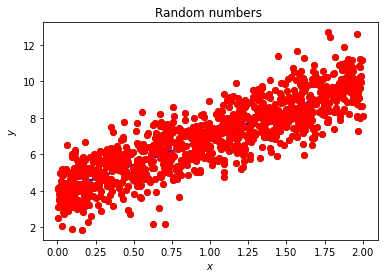

In [2]:
%matplotlib inline

# Importing various packages
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor

n = 1000
x = 2*np.random.rand(n,1)
y = 4+3*x+np.random.randn(n,1)

X = np.c_[np.ones((n,1)), x]


model=OLSRegression(X,y.ravel())
intercept = model.split().fit()[0]
std = np.std(model.y_train)

#model.rescale()

theta_linreg = np.linalg.pinv(model.X_train.T @ model.X_train) @ (model.X_train.T @ model.y_train)
beta_linreg = model.fit()

print("Own inversion")
print(theta_linreg)
print(beta_linreg)


sgdreg = SGDRegressor(max_iter = 50, penalty=None, eta0=0.1,fit_intercept=False)
sgdreg.fit(X, y.ravel())
print("sgdreg from scikit")

beta = sgdreg.coef_
if False:
    beta[0] = sgdreg.intercept_
            
print(beta)


theta = np.random.randn(2,1)
eta = 0.1
Niterations = 1000


for iter in range(Niterations):
    gradients = 2.0/n * X.T @ ((X @ theta)-y)
    theta -= eta*gradients
print("theta from own gd")
print(theta)

xnew = np.array([[0],[2]])
Xnew = np.c_[np.ones((2,1)), xnew]
ypredict = X.dot(theta)
ypredict2 = X.dot(theta_linreg)
plt.plot(x, ypredict, "r-")
plt.plot(x, ypredict2, "b-")


n_epochs = 50
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches
t0, t1 = 5, 50
def learning_schedule(t):
    return t0/(t+t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2.0 * xi.T @ ((xi @ theta)-yi)
        eta = learning_schedule(epoch*m+i)
        theta = theta - eta*gradients
print("theta from own sdg")
print(theta)

plt.plot(x, y ,'go') 

std_x=np.std(x)
m_x=np.mean(x)
scaler_X = StandardScaler()
scaler_X.fit(x)
x = scaler_X.transform(x)

m_y=np.mean(y)
std_y=np.std(y)
scaler_y = StandardScaler()
y2 = scaler_y.fit_transform(y.reshape(-1, 1)) #scaler_y.fit_transform(y_train) #"""

print(intercept)
print(std)
plt.plot(m_x+x*std_x, m_y+y2.ravel()*std_y ,'ro')
#plt.axis([0,2.0,0, 15.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Random numbers ')
plt.show()